
Grid Layout (0 = free, 1 = obstacle):
0 0 0 0 1 0 1 0 0 0
0 0 1 0 0 0 0 0 0 0
1 0 1 1 0 0 1 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 1 1 0 1 0 0 0 0
0 1 1 1 0 0 1 1 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 0
1 0 0 0 0 0 0 0 0 0
0 1 0 1 0 1 0 0 0 0
Starting patrol with A* path planning...


Planning path from (0, 0) to (2, 2)...
No path found! Skipping waypoint.

Planning path from (0, 0) to (7, 3)...
Moving to (0, 1)
Logged visit at (0, 1) at 2025-04-26 14:26:19
Moving to (1, 1)
Logged visit at (1, 1) at 2025-04-26 14:26:19
Moving to (2, 1)
Logged visit at (2, 1) at 2025-04-26 14:26:19
Moving to (3, 1)
Logged visit at (3, 1) at 2025-04-26 14:26:19
New dynamic obstacle at (2,1)! Replanning...

Planning path from (3, 1) to (5, 8)...
New dynamic obstacle at (1,6)! Replanning...

Planning path from (3, 1) to (0, 0)...
Moving to (3, 2)
Logged visit at (3, 2) at 2025-04-26 14:26:19
Moving to (3, 3)
Logged visit at (3, 3) at 2025-04-26 14:26:19
Moving to (3, 4)
Logged visit at (3, 4) at 2025-04-26 14:

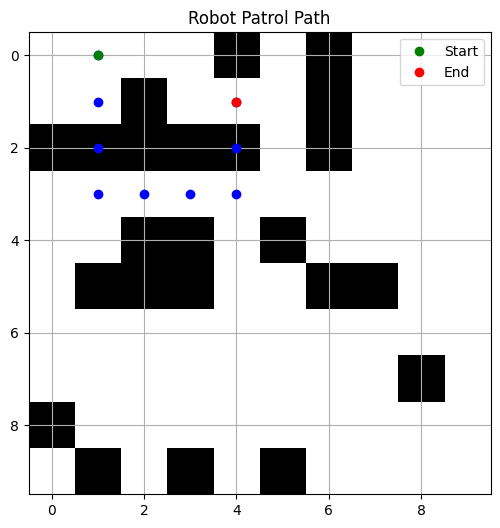

In [1]:
# Install matplotlib if not available (optional, usually preinstalled)
!pip install matplotlib --quiet

import heapq
import random
import time
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

class AStarPlanner:
    def __init__(self, grid):
        self.grid = grid
        self.rows = len(grid)
        self.cols = len(grid[0])

    def heuristic(self, a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])  # Manhattan distance

    def get_neighbors(self, node):
        neighbors = []
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            x2, y2 = node[0] + dx, node[1] + dy
            if 0 <= x2 < self.rows and 0 <= y2 < self.cols and self.grid[x2][y2] == 0:
                neighbors.append((x2, y2))
        return neighbors

    def a_star_search(self, start, goal):
        heap = [(0, start)]
        came_from = {}
        cost_so_far = {start: 0}

        while heap:
            _, current = heapq.heappop(heap)

            if current == goal:
                break

            for neighbor in self.get_neighbors(current):
                new_cost = cost_so_far[current] + 1
                if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                    cost_so_far[neighbor] = new_cost
                    priority = new_cost + self.heuristic(neighbor, goal)
                    heapq.heappush(heap, (priority, neighbor))
                    came_from[neighbor] = current

        # Reconstruct path
        path = []
        node = goal
        while node != start:
            path.append(node)
            node = came_from.get(node)
            if node is None:
                return None  # No path found
        path.append(start)
        path.reverse()
        return path

class RobotPatrol:
    def __init__(self, waypoints, grid_size=10, obstacle_count=15):
        self.grid_size = grid_size
        self.grid = [[0 for _ in range(grid_size)] for _ in range(grid_size)]
        self.place_random_obstacles(obstacle_count)
        self.waypoints = waypoints
        self.position = (0, 0)
        self.patrol_log = []
        self.planner = AStarPlanner(self.grid)

    def place_random_obstacles(self, count):
        placed = 0
        while placed < count:
            x, y = random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)
            if (x, y) != (0, 0) and self.grid[x][y] == 0:
                self.grid[x][y] = 1  # 1 means obstacle
                placed += 1

    def log_patrol(self, location):
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        self.patrol_log.append({
            "timestamp": timestamp,
            "position": location
        })
        print(f"Logged visit at {location} at {timestamp}")

    def patrol(self):
        print("Starting patrol with A* path planning...\n")
        waypoints = self.waypoints + [(0, 0)]  # Return to start

        for wp in waypoints:
            print(f"\nPlanning path from {self.position} to {wp}...")
            path = self.planner.a_star_search(self.position, wp)

            if not path:
                print("No path found! Skipping waypoint.")
                continue

            for step in path[1:]:  # Skip current position
                # Simulate random obstacle appearing dynamically
                if random.random() < 0.1:
                    ox, oy = random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)
                    if self.grid[ox][oy] == 0 and (ox, oy) != step:
                        self.grid[ox][oy] = 1
                        print(f"New dynamic obstacle at ({ox},{oy})! Replanning...")
                        break  # Replan from current position

                print(f"Moving to {step}")
                self.position = step
                self.log_patrol(step)
                # No sleep to speed up in Colab

    def show_patrol_log(self):
        print("\nPatrol Log:")
        for entry in self.patrol_log:
            print(f"{entry['timestamp']} - {entry['position']}")

    def show_grid(self):
        print("\nGrid Layout (0 = free, 1 = obstacle):")
        for row in self.grid:
            print(' '.join(str(cell) for cell in row))

    def plot_grid(self):
        grid_array = np.array(self.grid)
        plt.figure(figsize=(6,6))
        plt.imshow(grid_array, cmap="Greys", origin="upper")

        for entry in self.patrol_log:
            y, x = entry['position']
            plt.plot(x, y, 'bo')  # Mark patrol path in blue

        start_y, start_x = self.patrol_log[0]['position']
        plt.plot(start_x, start_y, 'go', label="Start")  # Start Green
        end_y, end_x = self.patrol_log[-1]['position']
        plt.plot(end_x, end_y, 'ro', label="End")  # End Red

        plt.legend()
        plt.title("Robot Patrol Path")
        plt.grid(True)
        plt.show()

# Run everything
if __name__ == "__main__":
    waypoints = [(2, 2), (7, 3), (5, 8)]
    robot = RobotPatrol(waypoints, grid_size=10, obstacle_count=20)
    robot.show_grid()
    robot.patrol()
    robot.show_patrol_log()
    robot.plot_grid()
